In [27]:
pwd

'/Users/ozkansafak/code/fraktur/notebooks'

In [26]:
%%time
%load_ext autoreload
%autoreload 2

# import standard Python modules
import time 
import numpy as np
import os, sys
import json
import re
import glob
import openai

# # Get the root path of the project
sys.path.append(os.path.abspath(".."))

# Import necessary modules from your src directory
from src.utils import timeit, encode_image, plt
from src.processing import compute_log_spectrum_1d, extract_image_bbox, save_images
from src.api_requests import construct_payload, send_gpt_request
from src.document_generation import save_document
from src.api_requests import single_page

from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

print('sys.executable:', sys.executable)
print('sys.version:', sys.version, '\n')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<timed exec>:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display


sys.executable: /Users/ozkansafak/code/fraktur/.venv/bin/python3
sys.version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ] 

CPU times: user 1.69 ms, sys: 1.37 ms, total: 3.06 ms
Wall time: 2.29 ms


---
## Fraktur Translator

In [80]:
# Set the OpenAI API key from environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")

# Set the headers for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
}

# Select the value of model_name in ["gpt-4o-2024-08-06", "gpt-4o-mini-2024-07-18"]
model_name = "gpt-4o-mini-2024-07-18"
plotter = True

# Folder containing the Fraktur PDF files
image_path = "../data/Der Weltkrieg v8 Chap 4F (in Fraktur)/*pdf"

# Get the list of PDF file paths
fnames = sorted(glob.glob(image_path))
# german_texts = {}
# english_texts = {}
total_time = 0 


>>>>>>>>>> page:456 (i:0/83) 

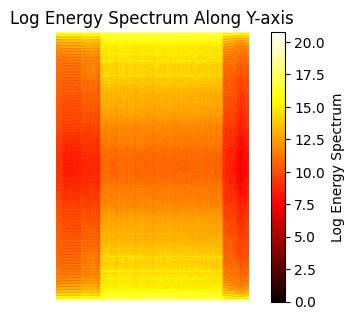

lo: 333
hi: 1274


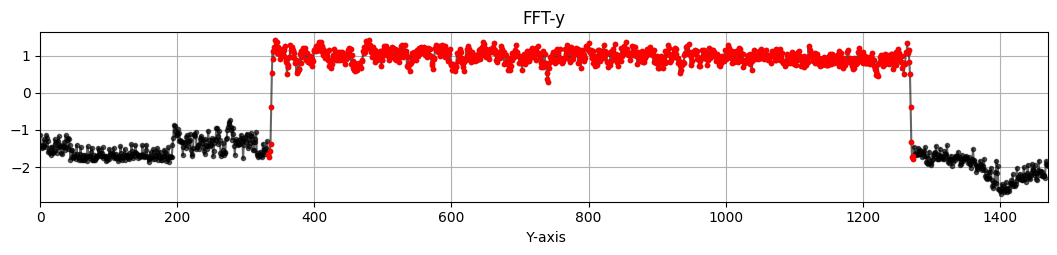

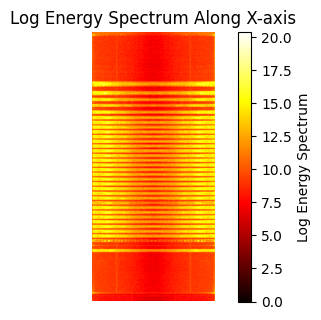

lo: 380
hi: 1695


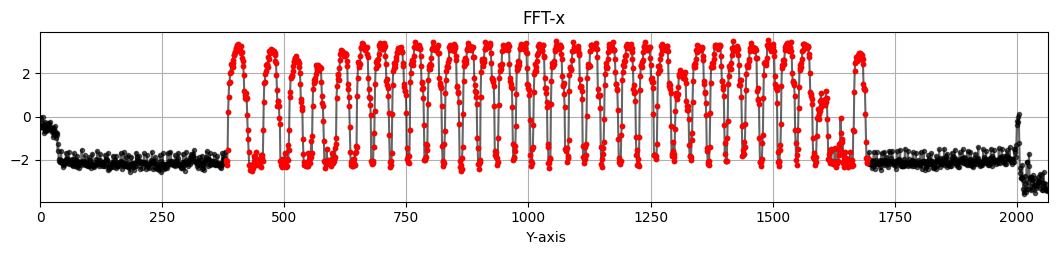

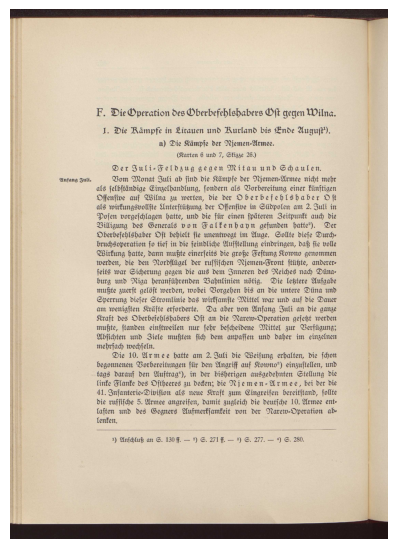

<Figure size 600x220 with 0 Axes>

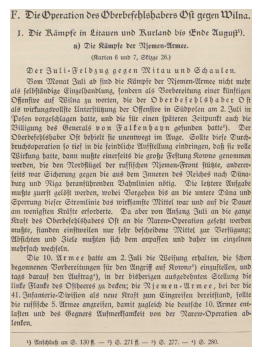

[time:25.97sec] [TotalRuntime:2 mins 55.01 sec] >>>>>>>>>>

<raw_german>
F. Die Operation des Oberbefehlshabers Ost gegen Wilna. 
I. Die Kämpfe in Litauen und Kurland bis Ende August¹). 
a) Die Kämpfe der Niemen-Armee. 
(Karten 6 und 7, Tische 26). 
Der Juli-Feldzug gegen Mitau und Schauen. 
Vom Monat Juli ab sind die Kämpfe der Niemen-Armee nicht mehr als selbständige Einzelhandlung, sondern als Vorbereitung einer künftigen Offensive auf Wilna zu werten, die der Oberbefehlshaber Ost als wirksame Unterstützung der Offensive in Südpolen am 2. Juli in Posen vorgeschlagen hatte, und die für einen späteren Zeitpunkt auch die Billigung des Generals von Falkenhayn gefunden hatte). Die Oberbefehlshaber Ost behielt sie unentwegt im Auge. Sollte diese Durchbruchsoperation so tief in die feindliche Aufstellung eindringen, dass sie volle Wirkung hatte, dann musste einerseits die große Festung Kowno genommen werden, die den Nordflügel der russischen Niemen-Front sicherte, andererseits die Sicherun

In [117]:
for i, fname in enumerate(fnames[0:1]):
    start = time.time()

    pageno = re.search(r'page_(.*?)\.pdf', fname, re.DOTALL).group(1)
    print(f"\n{'>'*10} page:{pageno} (i:{i}/{len(fnames)-1}) ", end="")
    
    raw_text, raw_german_text, german_text, english_text = single_page(fname, model_name, headers, plotter, pageno)
    
    german_texts[pageno] = german_text
    english_texts[pageno] = english_text
    delta = time.time() - start 
    total_time += delta
    print(f"[time:{delta:.2f}sec] [TotalRuntime:{int(total_time//60)} mins {(total_time - int(total_time//60)*60):.2f} sec] {'>'*10}\n")
    print(raw_text)


In [94]:
# save json outputs
folder_name = 'third_attempt'
with open(f'../output/{folder_name}/english_texts.json', 'w') as f:
    json.dump(english_texts, f)
with open(f'../output/{folder_name}/german_texts.json', 'w') as f:
    json.dump(german_texts, f)

doc1, fname1 = save_document(german_texts, folder_name, language='German')
doc2, fname2 = save_document(english_texts, folder_name, language='English')


``` 
1.  Upload Input folder of pdfs to blob storage.
2.  Read file from s3.
3.  FFT in y -> (x_hi, x_lo), write half_cropped_image to s3
4.  FFT in x -> (y_hi, y_lo), write cropped_image to s3
5.  Read cropped image from s3 -> encode_image -> translate and transcribe -> JSON output

```

### Available models and pricing:
```
"gpt-4o-2024-08-06":
    "price_txt": "$2.50 / 1M input tokens"
    "price_img": "$0.001913 / 1500px^2"
    
"gpt-4o-mini-2024-07-18":
    "price_txt": "$0.150 / 1M input tokens"
    "price_img": "$0.003825 / 1500px^2"
    
```